In [1]:
import time

import pandas as pd
import numpy as np

import tomotopy as tp
import pprint

import collections
import gensim
from konlpy.tag import Komoran

from konlpy.corpus import kolaw

import matplotlib.pyplot as plt
import matplotlib.colors as clr


%matplotlib inline 


import matplotlib.font_manager as fm

fm.get_fontconfig_fonts()
fontpath = 'C:/Windows/Fonts/malgun.ttf' # For Windows
font_name = fm.FontProperties(fname=fontpath).get_name()
plt.rc('font', family=font_name)

%matplotlib inline

%config InlineBackend.figure_format = 'retina'



In [2]:
df = pd.read_csv("중복제거(진짜최종).csv", encoding='UTF-8')
df

,LINK,Title,Content,Date,Species,Year,Month,Day
0,http://news.khan.co.kr/kh_news/khan_art_view.h...,삼성전자 차 부품전장 사업 수장 교체,팀장에 이승욱 부사장 선임LG전자와 경쟁 치열해질 듯 삼성전자가 미래 먹거리인 자동...,2020-12-31,경향,2020,12,31
1,http://news.khan.co.kr/kh_news/khan_art_view.h...,25 시민 자율과 자치의 상상력을 발휘폭주하는 과학기술 말머리를 돌려라,기술 민주주의 얼마 전까지도 우리 사회 속 기술 수용은 그리 대중의 관심사가 아니었...,2020-12-31,경향,2020,12,31
2,http://news.khan.co.kr/kh_news/khan_art_view.h...,오늘의 인사 2021년 1월 1일,국무조정실국무총리비서실 국민생명지키기추진단 총괄기획팀장 양소영 뉴미디어총괄행정...,2020-12-31,경향,2020,12,31
3,http://news.khan.co.kr/kh_news/khan_art_view.h...,신축년 알리는 제야의 종 타종 행사 VR로 생생하게,SKT 서울시 홈페이지에 준비별도 기기 없이 PC스마트폰 감상 코로나19 확산으로 ...,2020-12-30,경향,2020,12,30
4,http://news.khan.co.kr/kh_news/khan_art_view.h...,건축자재 유통 플랫폼 엘리콘 2020년도 DMC 이노베이션캠프 창업경진대회 우수상 수상,머신러닝 기반 건축자재 유통 플랫폼 엘리콘이 2020년도 DMC이노베이션캠프 창업경...,2020-12-30,경향,2020,12,30
...,...,...,...,...,...,...,...,...
13906,https://www.donga.com/news/article/all/2010012...,동부건설 방범로봇 아파트 3758채 공급,동부건설은 올해 7개 단지에서 총 3758채를 공급한다고 26일 밝혔다 동부건설...,2010-01-27,동아,2010,1,27
13907,https://www.donga.com/news/article/all/2010012...,반도체보다 빨리 크는 가전로봇시장,한국과학기술연구원은 인간형 로봇 마루가 구운 토스트와 전자레인지 안의 컵을 사람에...,2010-01-20,동아,2010,1,20
13908,https://www.donga.com/news/article/all/2010011...,법인화 이후 도쿄대는 달라지고 있다,일본 도쿄대를 중심으로 2004년 모든 일본 국립대학이 법인화됐다 5년이 지난...,2010-01-15,동아,2010,1,15
13909,https://www.donga.com/news/article/all/2010010...,녹색두뇌여 녹색혁명을 일으켜라,에코 지능 대니얼 골먼 지음이수경 옮김 360쪽1만8000원웅진지식하우스추운 2...,2010-01-09,동아,2010,1,9


In [3]:
def get_coherence(model, coherence=None, topn=None, processes=None):
    
    topics = []
    for k in range(model.k):
        word_probs = model.get_topic_words(k, topn)
        topics.append([word for word, prob in word_probs])
     
    texts = []
    corpus = []
    for doc in model.docs:
        words = [model.vocabs[token_id] for token_id in doc.words]
        texts.append(words)
        freqs = list(collections.Counter(doc.words).items())                  
        corpus.append(freqs)
    
    id2word = dict(enumerate(model.vocabs))
    dictionary = gensim.corpora.dictionary.Dictionary.from_corpus(corpus, id2word)
    
    cm = gensim.models.coherencemodel.CoherenceModel(
        topics=topics,
        texts=texts,
        corpus=corpus,
        dictionary=dictionary,  
        coherence=coherence,
        topn=topn,
        processes=processes,
    )

    return cm.get_coherence()

In [4]:
def compute_coherence_values(start, limit, step):
    starttime = time.time()
    for j in range(start, limit+1, step):
        remaintime = time.time()
        print(f"====={j}개짜리 토픽실행중... 실행중 포함 {int((limit-j)/step)+1} 경우의 수 남음=====")
                      
        mdl = tp.LDAModel(k=j)
        x = len(Content)
        for i in range(0,len(Content)):
            mdl.add_doc(Content[i])
            if i % 1390 == 0:
                runtime = time.time() - starttime
                print(f'{i}번째 기사 완료, {x-i}개 남음, 현재까지 총 {runtime}초걸림")')
           

        mdl.train(iter=50, workers=0)             
        
        coherence_value = get_coherence(mdl, coherence='c_v', topn=10, processes=5)

        print(f'Topic: {i}\tLog-likelihood: {mdl.ll_per_word}\tPerplexity: {mdl.perplexity}\tCoherence: {coherence_value}')
           
        coherence_values.append(coherence_value) 
        perplexities.append(mdl.perplexity)
        runtime = time.time() - remaintime
        if not int((limit-j)/step) == 0:
            print(f'남은 예상시간 : {runtime*int((limit-j)/step)}초')
        else:
            runtime = time.time() - starttime
            print(f"끝, {runtime}초걸림")

In [ ]:
komoran = Komoran()
stopwords = []
Content = []

starttime = time.time()

for i in df['Content']:
    morphs = komoran.nouns(i)
    pos = []

    for word in morphs:
        if not len(word) < 2:
            if word not in stopwords:
                pos.append(word)
    Content.append(pos)
    
runtime = time.time() - starttime
print(f"형태소 분석 끝, {runtime}초걸림")

* 매번 형태소 분석하는게 너무 오래걸려서, 미리 해두고 Content라는 리스트에 저장후, model에 넣어주는식으로 구성하였습니다. 
* 이전보다 훨신 빠른 속도로 나옵니다.
* 느린 이유로.. window에서 mecab을 사용하지못해서 okt, kkma, komoran등 많이 사용해봤는데, 나머지가 mecab보다는 너무 느린 나머지 이러한 방법으로 구성하였습니다.

In [6]:
coherence_values = []
perplexities = []  

limit = 100 #처음엔 그냥 10부터 100까지 돌려보고
start = 10
step = 5

compute_coherence_values(start, limit, step)

=====10개짜리 토픽실행중... 실행중 포함 19 경우의 수 남음=====
0번째 기사 완료, 13911개 남음, 현재까지 총 0.0초걸림")
1390번째 기사 완료, 12521개 남음, 현재까지 총 0.06881546974182129초걸림")
2780번째 기사 완료, 11131개 남음, 현재까지 총 0.1406238079071045초걸림")
4170번째 기사 완료, 9741개 남음, 현재까지 총 0.20943975448608398초걸림")
5560번째 기사 완료, 8351개 남음, 현재까지 총 0.2798783779144287초걸림")
6950번째 기사 완료, 6961개 남음, 현재까지 총 0.3397181034088135초걸림")
8340번째 기사 완료, 5571개 남음, 현재까지 총 0.40254998207092285초걸림")
9730번째 기사 완료, 4181개 남음, 현재까지 총 0.46089982986450195초걸림")
11120번째 기사 완료, 2791개 남음, 현재까지 총 0.5177476406097412초걸림")
12510번째 기사 완료, 1401개 남음, 현재까지 총 0.5930519104003906초걸림")
13900번째 기사 완료, 11개 남음, 현재까지 총 0.6469078063964844초걸림")
Topic: 13910	Log-likelihood: -8.438339042930801	Perplexity: 4620.87353448229	Coherence: 0.570665891938006
남은 예상시간 : 649.3597555160522초
=====15개짜리 토픽실행중... 실행중 포함 18 경우의 수 남음=====
0번째 기사 완료, 13911개 남음, 현재까지 총 36.085514307022095초걸림")
1390번째 기사 완료, 12521개 남음, 현재까지 총 36.1333863735199초걸림")
2780번째 기사 완료, 11131개 남음, 현재까지 총 36.18524742126465초걸림")
4170번째 기사 완료, 9741개 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001810B3EE580>,
      dtype=object)

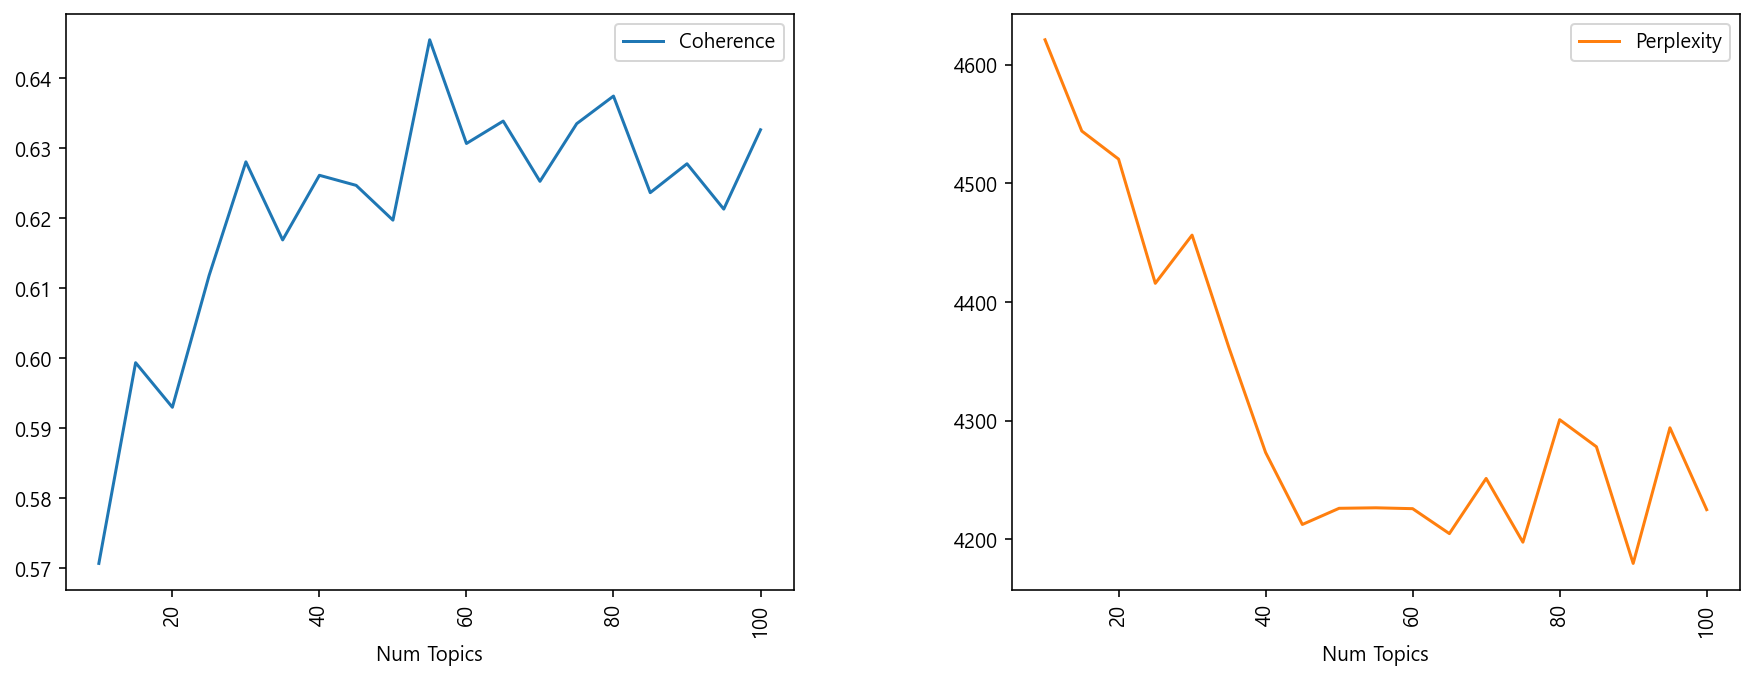

In [7]:
x = range(start, limit+1, step)


mdl_check = pd.DataFrame(list(zip(x, perplexities, coherence_values)), columns=['Num Topics', 'Perplexity', 'Coherence'])

fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2)

plt.subplots_adjust(left=0.125,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.5)

pd.pivot_table(mdl_check, values=["Perplexity", "Coherence"],index="Num Topics").plot(kind='line', rot=90, ax=ax, subplots=True)

In [22]:
k =  55   #<< (55 주변이 최적이기 때문에 일단 돌려서, stopwords를 채워주어야 함

starttime = time.time()

mdl = tp.LDAModel(k=k, min_cf=500, rm_top=10)


x = len(df['Content'])
for i in range(0,len(Content)): 
    text = Content[i]
    mdl.add_doc(text)
    if i % 1390 == 0:
        runtime = time.time() - starttime
        print(f'{i}번째 기사 완료, {x-i}개 남음, 현재까지 {runtime}초걸림")')


mdl.train(iter=100, workers=0) 
print(f'Iteration: {i}\tLog-likelihood: {mdl.ll_per_word}')

for k in range(mdl.k):
    print(f'Top 10 words of topic #{k}')
    print(mdl.get_topic_words(k, top_n=10))

runtime = time.time() - starttime
print(f"끝, {runtime}초걸림")

0번째 기사 완료, 13911개 남음, 현재까지 0.012964725494384766초걸림")
1390번째 기사 완료, 12521개 남음, 현재까지 0.06881546974182129초걸림")
2780번째 기사 완료, 11131개 남음, 현재까지 0.12126684188842773초걸림")
4170번째 기사 완료, 9741개 남음, 현재까지 0.17113351821899414초걸림")
5560번째 기사 완료, 8351개 남음, 현재까지 0.22100019454956055초걸림")
6950번째 기사 완료, 6961개 남음, 현재까지 0.2658810615539551초걸림")
8340번째 기사 완료, 5571개 남음, 현재까지 0.31472134590148926초걸림")
9730번째 기사 완료, 4181개 남음, 현재까지 0.3576068878173828초걸림")
11120번째 기사 완료, 2791개 남음, 현재까지 0.3995225429534912초걸림")
12510번째 기사 완료, 1401개 남음, 현재까지 0.4543764591217041초걸림")
13900번째 기사 완료, 11개 남음, 현재까지 0.49424195289611816초걸림")
Iteration: 13910	Log-likelihood: -6.9365988492889725
Top 10 words of topic #0
[('카카오', 0.08344802260398865), ('네이버', 0.0575789175927639), ('SK텔레콤', 0.043136656284332275), ('플랫폼', 0.039549898356199265), ('제공', 0.019108541309833527), ('스피커', 0.019076799973845482), ('이용', 0.01720406673848629), ('이용자', 0.016918396577239037), ('미니', 0.016569241881370544), ('기능', 0.01647401973605156)]
Top 10 words of topic #1
[

In [29]:
#mdl.save('stopwords-mdlresult(d,k).bin')
mdl = tp.LDAModel.load('stopwords-mdlresult(d,k).bin')
import pyLDAvis

topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq
prepared_data = pyLDAvis.prepare(topic_term_dists,doc_topic_dists,doc_lengths,vocab,term_frequency,mds='mmds')

C:\Users\LEE\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\LEE\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\LEE\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

* 적당한 k 값을 찾았으니, 최적의 k값 찾기 + 추가로 필요 없는 단어들 stopwords에 넣어주기

In [30]:
pyLDAvis.display(prepared_data)
# i = 1 '때문','필요','지금','자신','부분'
# i = 5 '제공'
# i = 10 '이번','올해','이날','오후'
# i = 11 '지난해','최근'
# i = 15 '필요',
# i = 19 '경우',
# i = 29 '때문','경우','정도',
# i = 37 '비대'
# i = 49 '지난해','대비','올해','전년'

형태소 분석 끝, 305.8084099292755초걸림
=====40개짜리 토픽실행중... 실행중 포함 11 경우의 수 남음=====
0번째 기사 완료, 13911개 남음, 현재까지 총 0.0초걸림")
1390번째 기사 완료, 12521개 남음, 현재까지 총 0.05881357192993164초걸림")
2780번째 기사 완료, 11131개 남음, 현재까지 총 0.12267184257507324초걸림")
4170번째 기사 완료, 9741개 남음, 현재까지 총 0.18350696563720703초걸림")
5560번째 기사 완료, 8351개 남음, 현재까지 총 0.24733376502990723초걸림")
6950번째 기사 완료, 6961개 남음, 현재까지 총 0.30219101905822754초걸림")
8340번째 기사 완료, 5571개 남음, 현재까지 총 0.36000847816467285초걸림")
9730번째 기사 완료, 4181개 남음, 현재까지 총 0.4148890972137451초걸림")
11120번째 기사 완료, 2791개 남음, 현재까지 총 0.46475815773010254초걸림")
12510번째 기사 완료, 1401개 남음, 현재까지 총 0.5315487384796143초걸림")
13900번째 기사 완료, 11개 남음, 현재까지 총 0.5814158916473389초걸림")
Topic: 13910	Log-likelihood: -8.357451037216068	Perplexity: 4261.817694963204	Coherence: 0.6336324957792735
남은 예상시간 : 495.6001353263855초
=====42개짜리 토픽실행중... 실행중 포함 10 경우의 수 남음=====
0번째 기사 완료, 13911개 남음, 현재까지 총 49.569475173950195초걸림")
1390번째 기사 완료, 12521개 남음, 현재까지 총 49.616379499435425초걸림")
2780번째 기사 완료, 11131개 남음, 현재까지 총 49.66

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000181546F1B50>,
      dtype=object)

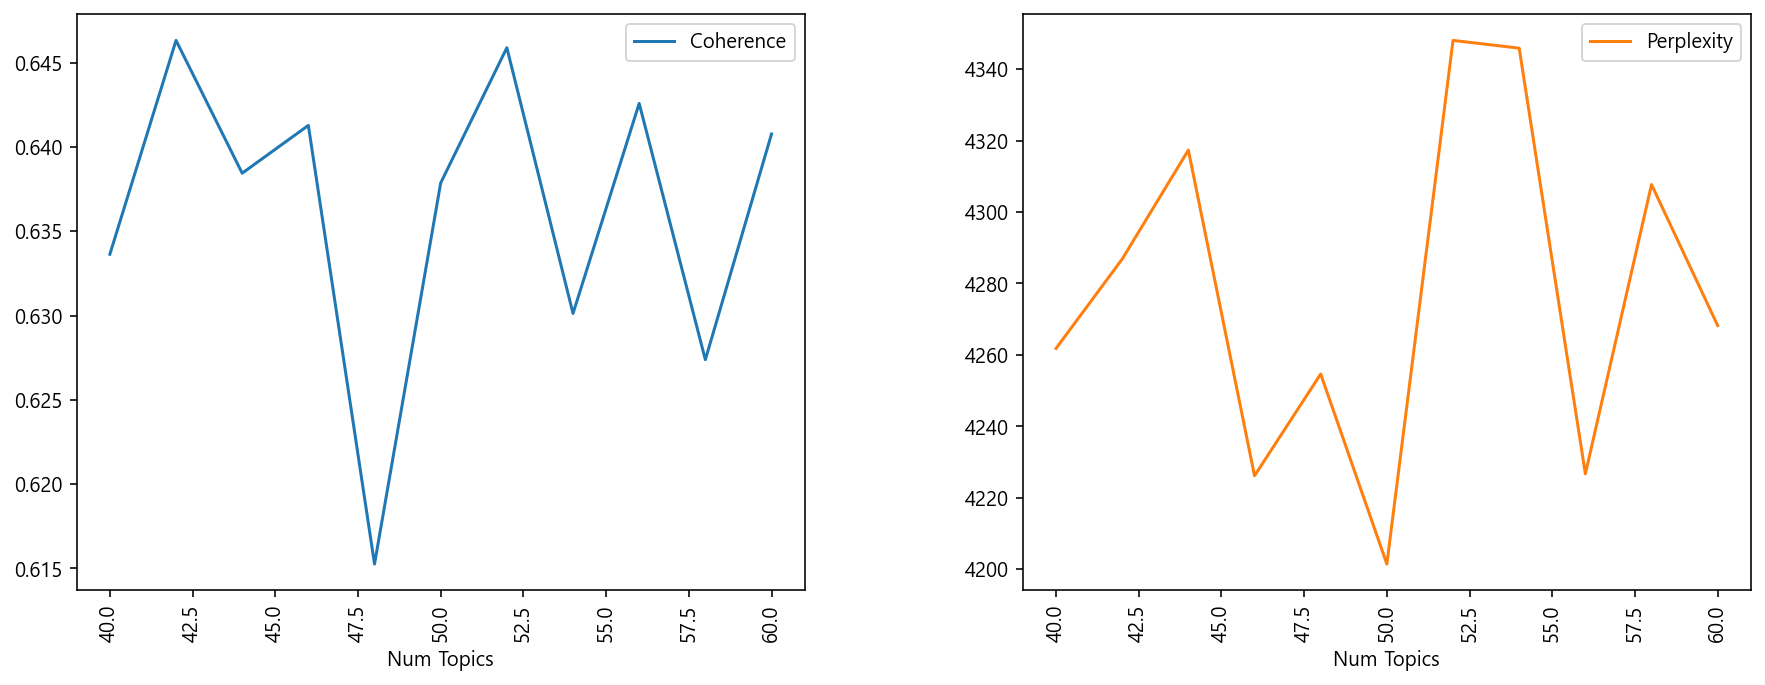

In [67]:
komoran = Komoran()
stopwords = ['때문','필요','지금','자신','부분','제공','이번','올해','이날','오후','지난해','최근','필요','경우','때문','경우','정도','비대','지난해','대비','올해','전년']
Content = []

starttime = time.time()

for i in df['Content']:
    morphs = komoran.nouns(i)
    pos = []

    for word in morphs:
        if not len(word) < 2:
            if word not in stopwords:
                pos.append(word)
    Content.append(pos)
    
runtime = time.time() - starttime
print(f"형태소 분석 끝, {runtime}초걸림")

coherence_values = []
perplexities = []  

limit = 60 # 아까 찾은 k = 55에서 stopword를 넣었으니 40~60으로 설정
start = 40 
step = 2

compute_coherence_values(start, limit, step)

x = range(start, limit+1, step)


mdl_check = pd.DataFrame(list(zip(x, perplexities, coherence_values)), columns=['Num Topics', 'Perplexity', 'Coherence'])

fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2)

plt.subplots_adjust(left=0.125,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.5)

pd.pivot_table(mdl_check, values=["Perplexity", "Coherence"],index="Num Topics").plot(kind='line', rot=90, ax=ax, subplots=True)

* perplexity는 낮을수록, coherence는 높을수록 일반적으로 우수하다고 평가함
* 최적의 K값 -> 52

In [68]:
K =  52   #<< K입력

starttime = time.time()

mdl = tp.LDAModel(k=K, min_cf=500, rm_top=10)


x = len(df['Content'])
for i in range(0,len(Content)): 
    text = Content[i]
    mdl.add_doc(text)
    if i % 1390 == 0:
        runtime = time.time() - starttime
        print(f'{i}번째 기사 완료, {x-i}개 남음, 현재까지 {runtime}초걸림")')


mdl.train(iter=100, workers=0) 
print(f'Iteration: {i+1}\tLog-likelihood: {mdl.ll_per_word}')

for k in range(mdl.k):
    print(f'Top 10 words of topic #{k}')
    print(mdl.get_topic_words(k, top_n=10))

runtime = time.time() - starttime
print(f"끝, {runtime}초걸림")


#mdl.save(f'goodmodel_(k={K})_mdlresult(d,k).bin')
mdl = tp.LDAModel.load(f'goodmodel_(k={K})_mdlresult(d,k).bin')

0번째 기사 완료, 13911개 남음, 현재까지 0.015552520751953125초걸림")
1390번째 기사 완료, 12521개 남음, 현재까지 0.07242965698242188초걸림")
2780번째 기사 완료, 11131개 남음, 현재까지 0.1273210048675537초걸림")
4170번째 기사 완료, 9741개 남음, 현재까지 0.17917990684509277초걸림")
5560번째 기사 완료, 8351개 남음, 현재까지 0.23057770729064941초걸림")
6950번째 기사 완료, 6961개 남음, 현재까지 0.27648448944091797초걸림")
8340번째 기사 완료, 5571개 남음, 현재까지 0.32491469383239746초걸림")
9730번째 기사 완료, 4181개 남음, 현재까지 0.3697669506072998초걸림")
11120번째 기사 완료, 2791개 남음, 현재까지 0.41268014907836914초걸림")
12510번째 기사 완료, 1401개 남음, 현재까지 0.4695303440093994초걸림")
13900번째 기사 완료, 11개 남음, 현재까지 0.512413501739502초걸림")
Iteration: 13911	Log-likelihood: -6.908832094611389
Top 10 words of topic #0
[('삼성전자', 0.042148176580667496), ('LG전자', 0.041439808905124664), ('제품', 0.03652060031890869), ('화질', 0.0345529168844223), ('디스플레이', 0.03215234354138374), ('영상', 0.026957659050822258), ('시장', 0.025777049362659454), ('공개', 0.025383511558175087), ('화면', 0.01951981522142887), ('레드', 0.017591485753655434)]
Top 10 words of topic #1
[('시

In [69]:
import pyLDAvis

topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq
prepared_data = pyLDAvis.prepare(topic_term_dists,doc_topic_dists,doc_lengths,vocab,term_frequency,mds='mmds')

C:\Users\LEE\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\LEE\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\LEE\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

In [70]:
pyLDAvis.display(prepared_data)